# Import dependencies

In [133]:
import pandas as pd
from io import StringIO
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import ezkl
import torch
import torch.nn as nn
import torch.optim as optim
import os
from scipy import stats
import scipy
import onnxruntime
from dataclasses import dataclass
from typing import List, Dict


# Load Data

## Hype Prices

**PLEASE AVOID SPAMMING THIS LINE OTHERWISE WE GET RATE LIMITED**

In [134]:
url = "https://api.coingecko.com/api/v3/coins/hyperliquid/market_chart?vs_currency=usd&days=365&interval=daily"

headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": "CG-36bsacjiQd1F8rmk5z4j1tMs"
}

response = requests.get(url, headers=headers)

print(response.text)

{"prices":[[1732838400000,6.512709126014327],[1732924800000,6.512709126014327],[1733011200000,8.644603573199845],[1733097600000,9.459223086748034],[1733184000000,8.43020480298621],[1733270400000,11.16858001247626],[1733356800000,10.927396907589728],[1733443200000,12.59259618742528],[1733529600000,13.824764093589229],[1733616000000,14.148295136918554],[1733702400000,14.188638965497068],[1733788800000,13.390810695266785],[1733875200000,13.878510532121165],[1733961600000,16.160291494319157],[1734048000000,18.32086197907653],[1734134400000,19.445355374548534],[1734220800000,24.278950866911032],[1734307200000,24.06784264061239],[1734393600000,27.451297316399142],[1734480000000,25.590526995880662],[1734566400000,23.166825060814343],[1734652800000,25.041541157512242],[1734739200000,29.960485436304847],[1734825600000,32.40674492071673],[1734912000000,28.218793897378536],[1734998400000,28.312352202537458],[1735084800000,29.823925491530062],[1735171200000,26.788314746069965],[1735257600000,26.86

Store the last 20 days of daily price data to a CSV. Will use this later to seed the UniTickAttestor contract with the initial set of price data. 

In [135]:
response = requests.get(url, headers=headers)
price_json = json.loads(response.text)
prices = price_json["prices"]
prices_df = pd.DataFrame(prices)

prices_df.columns = ['Timestamp', 'Price']

# sort
prices_df = prices_df.sort_values('Timestamp')

# Scale price by 1e6 to match USDC decimals and convert to integer
prices_df['Price'] = (prices_df['Price'] * 1e6).astype(int)

# Remove the first row as it will have NaN for returns
prices_df = prices_df.dropna()

# Take only the first 20 
prices_20 = prices_df['Price'][-20:].dropna().values.tolist()

# Save only price columns to json
with open(os.path.join("data", "price_data.json"), 'w') as f:
    json.dump(prices_20, f)

In [136]:
prices_df = pd.DataFrame(prices)
prices_df[0] = pd.to_datetime(prices_df[0], unit='ms')

prices_df.columns = ['t', 'c']

# sort
prices_df = prices_df.sort_values('t')

# calculate pct return and log returns
prices_df['pct_returns'] = prices_df['c'].pct_change()
prices_df['log_returns'] = np.log(prices_df['c'] / prices_df['c'].shift(1))

# Remove the first row as it will have NaNs for returns
prices_df = prices_df.dropna()

# Display the first few rows of the modified DataFrame
print(prices_df.head())

# Display basic statistics of both types of returns
print("\nPercentage Returns Statistics:")
print(prices_df['pct_returns'].describe())

print("\nLog Returns Statistics:")
print(prices_df['log_returns'].describe())

           t          c  pct_returns  log_returns
1 2024-11-30   6.512709     0.000000     0.000000
2 2024-12-01   8.644604     0.327344     0.283180
3 2024-12-02   9.459223     0.094234     0.090055
4 2024-12-03   8.430205    -0.108785    -0.115169
5 2024-12-04  11.168580     0.324829     0.281283

Percentage Returns Statistics:
count    67.000000
mean      0.024200
std       0.098041
min      -0.129231
25%      -0.046812
50%       0.015005
75%       0.076029
max       0.327344
Name: pct_returns, dtype: float64

Log Returns Statistics:
count    67.000000
mean      0.019594
std       0.092704
min      -0.138378
25%      -0.047943
50%       0.014894
75%       0.073278
max       0.283180
Name: log_returns, dtype: float64


## GARCH -> ZKP with EZKL

Create a PyTorch Model and export to ONNX, for the model here we can just do a one step lookback and forecast. We can reapply the model for a longer forecast period

In [137]:
# FAIL: Unable to export vectorized model
class GARCHModel(nn.Module):
    def __init__(self, omega=[0.01], alpha=[0.1], beta=[0.8]):
        super(GARCHModel, self).__init__()
        self.omega = nn.Parameter(torch.tensor(omega, dtype=torch.float32))
        self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32))
        self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32))

    def forward(self, returns, n_forecast):
        T = returns.shape[0]
        variance = torch.zeros(T, dtype=torch.float32)
        variance[0] = returns.var()

        # Vectorized garch formula
        sqr_returns = returns[:-1]**2
        temp_var = self.omega + self.alpha * sqr_returns + self.beta * variance[:-1]
        variance = torch.cat([variance[:1], temp_var])

        # vectorized forecast
        last_variance = variance[-1]
        # TODO: This vectorized forecast is wrong !
        forecast = self.omega.expand(n_forecast) \
            + self.beta.expand(n_forecast) \
            * torch.pow(self.beta, torch.arange(n_forecast, dtype=torch.float32)) \
            * last_variance

        return variance, forecast

In [138]:
# FAIL: Unable to export due to loops
# We use this for training as we are able to forecast on a longer range
class GARCHModel2(nn.Module):
    def __init__(self, omega=[0.01], alpha=[0.1], beta=[0.8]):
        super(GARCHModel2, self).__init__()
        self.omega = nn.Parameter(torch.tensor(omega, dtype=torch.float32))
        self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32))
        self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32))

    def forward(self, returns, n_forecast):
        T = returns.shape[0]

        initial_variance = returns.var()

        variances = []
        current_variance = initial_variance

        for t in range(T-1):
            next_variance = (self.omega +
                           self.alpha * returns[t]**2 +
                           self.beta * current_variance)
            variances.append(next_variance)
            current_variance = next_variance

        variance = torch.cat([initial_variance.unsqueeze(0)] + variances).squeeze()

        last_variance = variance[-1]

        forecast = []
        current_forecast = self.omega + self.alpha * returns[-1]**2 + self.beta * variance[-1]  # h=1
        sqrt_current_forecast = torch.sqrt(current_forecast)
        forecast.append(current_forecast.squeeze())

        # For h > 1
        persistence = self.alpha + self.beta
        for _ in range(n_forecast - 1):
            current_forecast = self.omega + persistence * current_forecast

            # sqrt to get the standard deviation
            sqrt_current_forecast = torch.sqrt(current_forecast)
            forecast.append(sqrt_current_forecast.squeeze())

        # Stack and flatten the forecast
        forecast = torch.stack(forecast).squeeze()

        return variance, forecast


In [139]:
# OK: One step forecast only
class GARCHModel3(nn.Module):
    def __init__(self, omega=[0.01], alpha=[0.1], beta=[0.8], use_pct=False):
        super(GARCHModel3, self).__init__()
        self.omega = nn.Parameter(torch.tensor(omega, dtype=torch.float32))
        self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32))
        self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32))
        self.use_pct = use_pct

    def forward(self, prices):
        if len(prices.shape) == 1:
            prices = prices.unsqueeze(0)

        epsilon = 1e-6
        # Ensure all prices are positive by adding epsilon to prevent log(0)
        prices = torch.clamp(prices, min=epsilon)

        if self.use_pct:
            # compute the pct returns
            returns = prices[:, 1:] / prices[:,:-1] - 1
        else:
            # compute log returns
            returns = torch.log(prices[:, 1:] / prices[:,:-1])


        returns_squared = returns * returns
        last_variance = torch.mean(returns_squared, dim=1)

        last_return = returns[:, -1]
        last_return_squared = last_return * last_return

        forecast = self.omega + self.alpha * last_return_squared + self.beta * last_variance

        # return sqrt to get std deviation
        return torch.sqrt(forecast)


In [140]:
# Sanity checks
def test_model_output():
    """Test function to verify scalar output"""
    # Test input
    returns = torch.tensor([0.1, 0.2, 0.15, 0.1, 0.05], dtype=torch.float32)

    model = GARCHModel3()
    forecast = model(returns)

    print("Input shape:", returns.shape)
    print("Output value:", forecast)
    print("Output shape:", forecast.shape)

    return model

model = test_model_output()


Input shape: torch.Size([5])
Output value: tensor([0.5474], grad_fn=<SqrtBackward0>)
Output shape: torch.Size([1])


In [141]:
# Training function using a rolling window
def train_garch_torch(
        model,
        returns,
        train_window=14,
        validation_window=2,
        step=1,
        epochs=1000,
        lr=0.01,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    ):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    returns_tensor = torch.tensor(returns, dtype=torch.float32, device=device)
    criterion = nn.MSELoss()

    total_loss = 0
    n_iterations = 0

    for i in range(0, len(returns) - train_window - validation_window + 1, step):
        train_returns = returns_tensor[i:i+train_window]
        val_returns = returns_tensor[i+train_window:i+train_window+validation_window]

        for epoch in range(epochs):
            optimizer.zero_grad()
            # for model 1
            # _, predicted_forecast = model(
            #     train_returns, n_forecast=validation_window)
            # loss_out = criterion(predicted_forecast, val_returns**2)

            # for model 2
            _, predicted_forecast = model(
                train_returns, n_forecast=validation_window)
            loss_out = criterion(predicted_forecast, val_returns)


            # for model 3
            # predicted_forecast = model(train_returns)
            # # Note: because we already use the sqrt value in the function this is unnecessary
            # loss_out = criterion(predicted_forecast, val_returns)
            
            loss_out.backward()
            optimizer.step()

            # Apply constraints after the optimizer step
            with torch.no_grad():
                model.omega.data.clamp_(min=1e-2)
                model.alpha.data.clamp_(min=1e-2, max=1)
                model.beta.data.clamp_(min=1e-2, max=1)
                sum_params = model.alpha.data + model.beta.data
                sum_params.clamp_(max=1)

        total_loss += loss_out.item()
        n_iterations += 1

        if (i // step + 1) % 10 == 0:
            print(f'Window [{i//step + 1}], Avg Loss: {total_loss/n_iterations:.12f}')

    return model

In [142]:
garch_torch = GARCHModel2()
# We use log instead of pct returns as it seems to be stabler wrt to dgarch
# use 80% of data and use the remaining 20% for test
trained_garch_torch = train_garch_torch(
    garch_torch,
    prices_df['log_returns'][0:((len(prices_df) // 10) * 8)].dropna().values,
    train_window=14,
    validation_window=2,
    step=1,
    epochs=100,
    lr=0.0001
)

Window [10], Avg Loss: 0.026133309180
Window [20], Avg Loss: 0.025022096101
Window [30], Avg Loss: 0.022572355288


In [143]:
# Get test loss
def evaluate_garch_torch(
        model,
        test_returns,
        eval_window=20,
        forecast_window=3,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    ):
    model.eval()  # Set the model to evaluation mode
    model = model.to(device)
    criterion = nn.MSELoss()

    # Check if we have enough data for at least one evaluation
    if len(test_returns) < eval_window + forecast_window:
        raise ValueError(f"Test data length ({len(test_returns)}) is too short for evaluation. "
                         f"It should be at least {eval_window + forecast_window}.")

    test_returns_tensor = torch.tensor(test_returns, dtype=torch.float32, device=device)

    total_loss = 0
    n_windows = 0

    with torch.no_grad():
        for i in range(0, len(test_returns) - eval_window - forecast_window + 1, forecast_window):
            eval_returns = test_returns_tensor[i:i+eval_window]
            forecast_returns = test_returns_tensor[i+eval_window:i+eval_window+forecast_window]

            # model 1
            # _, predicted_forecast = model(
            #     eval_returns, n_forecast=forecast_window)
            # loss_out = criterion(predicted_forecast, forecast_returns**2)

            # model 2
            _, predicted_forecast = model(
                eval_returns, n_forecast=forecast_window)
            loss_out = criterion(predicted_forecast, forecast_returns)

            # model 3
            # predicted_forecast = model(
            #     eval_returns
            # )
            loss_out = criterion(predicted_forecast, forecast_returns)

            total_loss += loss_out.item()
            n_windows += 1

    if n_windows == 0:
        raise ValueError("No valid evaluation windows were created. "
                         "This might be due to the step size being larger than the available data.")

    avg_loss = total_loss / n_windows
    return avg_loss


In [144]:
test_returns = prices_df['log_returns'][((len(prices_df) // 10) * 8):].dropna().values

test_loss = evaluate_garch_torch(
    trained_garch_torch,
    test_returns,
    eval_window=14,
    forecast_window=2
)

print(f"Test Loss: {test_loss:.8f}")
print("Estimated parameters:")
print(f"Omega: {trained_garch_torch.omega.item():.10f}")
print(f"Alpha: {trained_garch_torch.alpha.item():.10f}")
print(f"Beta: {trained_garch_torch.beta.item():.10f}")

Test Loss: 0.02937837
Estimated parameters:
Omega: 0.0099999998
Alpha: 0.0099999998
Beta: 0.5446072221


In [145]:
def generate_test_predictions(
        model, test_returns, eval_window=20, forecast_window=1):
    model.eval()
    device = next(model.parameters()).device
    test_returns_tensor = torch.tensor(test_returns, dtype=torch.float32, device=device)

    predictions = []

    with torch.no_grad():
        for i in range(
            0,
            len(test_returns) - eval_window - forecast_window + 1, forecast_window
        ):
            eval_returns = test_returns_tensor[i:i+eval_window]

            # model 1
            # variances, forecast = model(
            #     eval_returns, n_forecast=forecast_window)
            
            # model 2
            variances, forecast = model(
                eval_returns, n_forecast=forecast_window)

            # model 3
            # forecast = model(
            #     eval_returns)

            # print(forecast)

            # Multiply prediction by 252 for the number of trading days in a year
            # We avoid using 365 as typically the volumes as the volatility really only coincides with trading days
            prediction = forecast.cpu().detach().item() * np.sqrt(252)
            predictions.append(prediction)

    # Pad the beginning with NaNs to match the length of test_returns
    padding = len(test_returns) - len(predictions)
    return np.pad(
        predictions, (padding, 0), mode='constant', constant_values=np.nan)

def plot_test_predictions(prices, test_returns, predicted_sd):
    # Ensure all inputs are numpy arrays
    prices = np.array(prices)
    test_returns = np.array(test_returns)
    predicted_sd = np.array(predicted_sd)

    # Create a date range for x-axis
    dates = pd.date_range(end=pd.Timestamp.today(), periods=len(prices))

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plot the price on the primary y-axis
    ax1.plot(dates, prices, color='blue', label='Price')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis for predicted sd
    ax2 = ax1.twinx()

    # Plot the predicted variance on the secondary y-axis
    # note we use 365 here as crypto is 24/7
    ax2.plot(dates, predicted_sd, color='red', label='Predicted Annualized Volatility')
    ax2.set_ylabel('Predicted Annualized Volatility', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.title('Price vs Predicted Annualized Volatility (Test Data)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def print_summary_statistics(prices, predicted_sd):
    print("Price Statistics:")
    print(pd.Series(prices).describe())
    print("\nPredicted Volatility Statistics:")
    print(pd.Series(predicted_sd).describe())


def evaluate_and_visualize_dgarch(model, test_prices, test_returns, eval_window=14, forecast_window=1):
    # Generate predictions for the test data
    predicted_sd = generate_test_predictions(model, test_returns, eval_window, forecast_window)

    # Plot the results
    plot_test_predictions(test_prices, test_returns, predicted_sd)

    # Print summary statistics
    print_summary_statistics(test_prices, predicted_sd)

    return predicted_sd


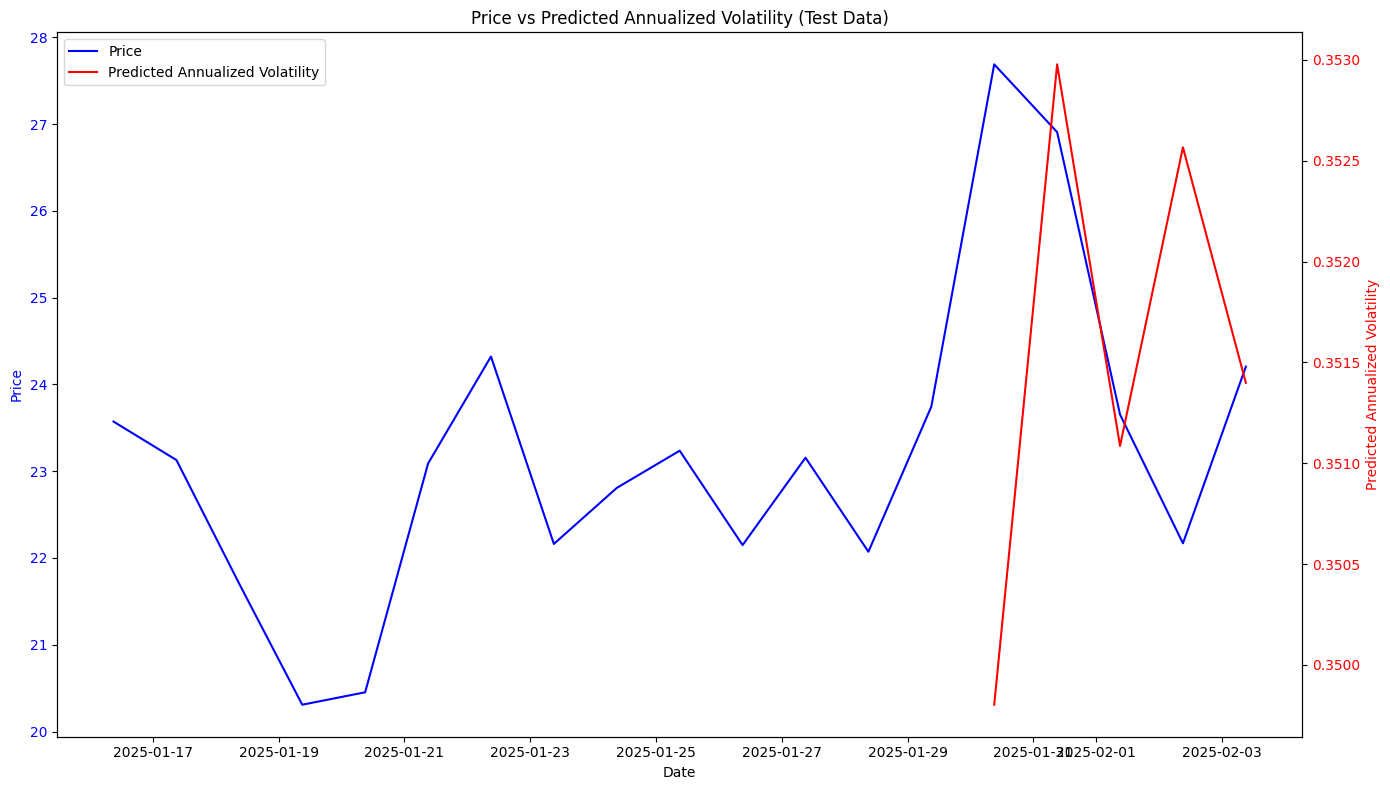

Price Statistics:
count    19.000000
mean     23.185402
std       1.820384
min      20.309249
25%      22.155318
50%      23.128838
75%      23.698550
max      27.688728
dtype: float64

Predicted Volatility Statistics:
count    5.000000
mean     0.351566
std      0.001261
min      0.349802
25%      0.351085
50%      0.351399
75%      0.352566
max      0.352978
dtype: float64


In [146]:
test_returns = prices_df['log_returns'][((len(prices_df) // 10) * 8):].dropna().values

test_prices = prices_df['c'][((len(prices_df) // 10) * 8):].dropna().values

predicted_variance = evaluate_and_visualize_dgarch(
    trained_garch_torch, test_prices, test_returns)



In [147]:
def garch_forecast(model, returns, n_forecast=1):
    model.eval()
    returns = torch.tensor(returns.values, dtype=torch.float32)

    conditional_variances, volatility_forecast = model(returns, n_forecast)

    return conditional_variances, volatility_forecast

In [148]:
model = trained_garch_torch
n_forecast = 5  # Forecast for the next 5 days
conditional_variances_pct, volatility_forecast_pct = garch_forecast(model, prices_df['pct_returns'], n_forecast=n_forecast)

conditional_variances_log, volatility_forecast_log = garch_forecast(model, prices_df['log_returns'], n_forecast=n_forecast)

print(volatility_forecast_pct)

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Forecasted_Volatility_pct': volatility_forecast_pct.detach().numpy(),
    'Forecasted_Volatility_log': volatility_forecast_log.detach().numpy()
})

print("Historical Conditional Variances (PCT):")
print(conditional_variances_pct[-5:])  # Last 5 historical variances
print("Historical Conditional Variances (LOG):")
print(conditional_variances_log[-5:])  # Last 5 historical variances
print("\nForecasted Volatilities:")
print(results_df)

tensor([0.0221, 0.1493, 0.1495, 0.1497, 0.1497], grad_fn=<SqueezeBackward0>)
Historical Conditional Variances (PCT):
tensor([0.0220, 0.0223, 0.0221, 0.0222, 0.0221], grad_fn=<SliceBackward0>)
Historical Conditional Variances (LOG):
tensor([0.0220, 0.0222, 0.0221, 0.0222, 0.0221], grad_fn=<SliceBackward0>)

Forecasted Volatilities:
   Forecasted_Volatility_pct  Forecasted_Volatility_log
0                   0.022138                   0.022134
1                   0.149257                   0.149251
2                   0.149517                   0.149514
3                   0.149661                   0.149659
4                   0.149741                   0.149740


In [149]:
def export_garch_to_onnx(
        model,
        model_path="garch_model.onnx",
        returns_length=20,
        n_forecast=1
    ):
    model.eval()  # Set the model to evaluation mode

    # Create dummy input tensor
    real_returns = prices_df['c'][-20:].dropna().values
    x = torch.tensor(real_returns, dtype=torch.float32).reshape(1, -1)

    # Export the model
    torch.onnx.export(
        model,                     # model being run
        x,                         # model input (or a tuple for multiple inputs)
        model_path,                # where to save the model
        export_params=True,        # store the trained parameter weights inside the model file
        opset_version=10,          # the ONNX version to export the model to
        do_constant_folding=True,  # whether to execute constant folding for optimization
        input_names=['input'],     # the model's input names
        output_names=['output'],   # the model's output names
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )

    print(f"Model exported to {model_path}")

    data_array = x.detach().numpy().reshape([-1]).tolist()
    data = {
        "input_data": [data_array]
    }

    with open(os.path.join("data", "input.json"), 'w') as f:
        json.dump(data, f)

    return x

In [150]:
# use model 3 with optimal values from model 2
optimal_garch_torch_log = GARCHModel3(
    omega=[0.0099999998],
    alpha=[0.0099999998],
    beta=[0.0099999998],
    use_pct=False
)

optimal_garch_torch_pct = GARCHModel3(
    omega=[0.0099999998],
    alpha=[0.0099999998],
    beta=[0.0099999998],
    use_pct=True
)

export_garch_to_onnx(optimal_garch_torch_log, os.path.join("data", "garch_model_log.onnx"))
export_garch_to_onnx(optimal_garch_torch_pct, os.path.join("data", "garch_model_pct.onnx"))

Model exported to data/garch_model_log.onnx
Model exported to data/garch_model_pct.onnx


tensor([[24.2483, 23.5718, 23.1288, 21.7006, 20.3092, 20.4523, 23.0882, 24.3222,
         22.1620, 22.8075, 23.2363, 22.1486, 23.1557, 22.0717, 23.7441, 27.6887,
         26.9077, 23.6530, 22.1692, 24.2049]])

## Test ONNX File
**The values sorta checks out**, lets proceed with SNARKing it with EZKL 🤔

In [151]:
def test_onnx_model(
    pytorch_model,
    onnx_path="garch_model.onnx",
    input_json_path="input.json",
    rtol=1e-03,
    atol=1e-05
):
    """
    Test ONNX model output against PyTorch model

    Args:
        pytorch_model: Original PyTorch model
        onnx_path: Path to exported ONNX model
        input_json_path: Path to input data JSON
        rtol: Relative tolerance for comparison
        atol: Absolute tolerance for comparison
    """
    with open(input_json_path, 'r') as f:
        input_data = json.load(f)

    input_numpy = np.array(input_data["input_data"][0], dtype=np.float32)

    ort_session = onnxruntime.InferenceSession(onnx_path)

    ort_inputs = {
        'input': input_numpy.reshape(1, -1)
    }

    ort_output = ort_session.run(None, ort_inputs)[0]

    pytorch_input = torch.tensor(input_numpy, dtype=torch.float32)
    with torch.no_grad():
        pytorch_output = pytorch_model(pytorch_input).numpy()

    print("\nModel Comparison Results:")
    print("-" * 50)
    print(f"Input shape: {input_numpy.shape}")
    print(f"\nPyTorch output: {pytorch_output}")
    print(f"ONNX output: {ort_output}")
    print(f"\nAbsolute difference: {np.abs(pytorch_output - ort_output)}")

    np.testing.assert_allclose(
        pytorch_output,
        ort_output,
        rtol=rtol,
        atol=atol,
        err_msg="ONNX and PyTorch outputs do not match within tolerance!"
    )
    print("\nSuccess: ONNX and PyTorch outputs match within tolerance!")

    return {
        'pytorch_output': pytorch_output,
        'onnx_output': ort_output,
        'input_data': input_numpy
    }


In [152]:

# Test the exported model
try:
    results = test_onnx_model(
        optimal_garch_torch_log, 
        onnx_path=os.path.join("data", "garch_model_log.onnx"),
        input_json_path=os.path.join("data", "input.json")
    )

    # Additional verification if needed
    print("\nDetailed Input/Output Analysis:")
    print("-" * 50)
    print(f"First few input values: {results['input_data'][:5]}")
    print(f"PyTorch model parameters:")
    for name, param in optimal_garch_torch_log.named_parameters():
        print(f"{name}: {param.data}")

    results = test_onnx_model(
        optimal_garch_torch_pct, 
        onnx_path=os.path.join("data", "garch_model_pct.onnx"),
        input_json_path=os.path.join("data", "input.json")
    )

    # Additional verification if needed
    print("\nDetailed Input/Output Analysis:")
    print("-" * 50)
    print(f"First few input values: {results['input_data'][:5]}")
    print(f"PyTorch model parameters:")
    for name, param in optimal_garch_torch_log.named_parameters():
        print(f"{name}: {param.data}")

except Exception as e:
    print(f"Error during testing: {str(e)}")


Model Comparison Results:
--------------------------------------------------
Input shape: (20,)

PyTorch output: [0.10065158]
ONNX output: [0.10065158]

Absolute difference: [0.]

Success: ONNX and PyTorch outputs match within tolerance!

Detailed Input/Output Analysis:
--------------------------------------------------
First few input values: [24.2483   23.571836 23.128838 21.700577 20.309248]
PyTorch model parameters:
omega: tensor([0.0100])
alpha: tensor([0.0100])
beta: tensor([0.0100])

Model Comparison Results:
--------------------------------------------------
Input shape: (20,)

PyTorch output: [0.10069611]
ONNX output: [0.10069611]

Absolute difference: [0.]

Success: ONNX and PyTorch outputs match within tolerance!

Detailed Input/Output Analysis:
--------------------------------------------------
First few input values: [24.2483   23.571836 23.128838 21.700577 20.309248]
PyTorch model parameters:
omega: tensor([0.0100])
alpha: tensor([0.0100])
beta: tensor([0.0100])


In [153]:
# Generate Settings
py_run_args = ezkl.PyRunArgs()
py_run_args.input_visibility = "public"
py_run_args.param_visibility = "fixed"
py_run_args.output_visibility = "public"
py_run_args.bounded_log_lookup = True
py_run_args.decomp_base = 16384 * 2
py_run_args.decomp_legs = 4

res = ezkl.gen_settings(
    model=os.path.join("data", "garch_model_log.onnx"), 
    output=os.path.join("data", "settings.json"),
    py_run_args=py_run_args
)
assert res == True


In [154]:
# Optimize for resources
res = await ezkl.calibrate_settings(
    data=os.path.join("data", "input.json"), 
    model=os.path.join("data", "garch_model_log.onnx"),
    settings=os.path.join("data", "settings.json"),
    target = "resources"
)

[tensor] decomposition error: integer -1599293990152068096 is too large to be represented by base 32768 and n 4
forward pass failed: "failed to forward: [halo2] General synthesis error"
[tensor] decomposition error: integer -2679669351373921583105 is too large to be represented by base 32768 and n 4
forward pass failed: "failed to forward: [halo2] General synthesis error"
[tensor] decomposition error: integer -129336955708808805482497 is too large to be represented by base 32768 and n 4
forward pass failed: "failed to forward: [halo2] General synthesis error"
[tensor] decomposition error: integer -2679669351373921583105 is too large to be represented by base 32768 and n 4
forward pass failed: "failed to forward: [halo2] General synthesis error"
[tensor] decomposition error: integer -18642194094796711510017 is too large to be represented by base 32768 and n 4
forward pass failed: "failed to forward: [halo2] General synthesis error"
[tensor] decomposition error: integer -1864219409479671

**Note:** I thought the error was large but I realized the values were also large so it isn't too bad.

In [155]:
# compile circuit
res = ezkl.compile_circuit(
    model=os.path.join("data", "garch_model_log.onnx"),
    compiled_circuit=os.path.join("data", "model.compiled"),
    settings_path=os.path.join("data", "settings.json"),
)
assert res == True

In [156]:
# get srs
res = await ezkl.get_srs(settings_path=os.path.join("data", "settings.json"))


In [157]:
# setup
res = ezkl.setup(
    model=os.path.join("data", "model.compiled"),
    vk_path=os.path.join("data", "vk.key"),
    pk_path=os.path.join("data", "pk.key"),
)

assert res == True

In [158]:
# generate witness
res = await ezkl.gen_witness(
    data=os.path.join("data", "input.json"), 
    model=os.path.join("data", "model.compiled"),
    output=os.path.join("data", "witness.json")
)
assert os.path.isfile(os.path.join("data", "witness.json"))

In [159]:
# generate proof
proof_path = os.path.join("data", "proof.json")
proof = ezkl.prove(
    witness=os.path.join("data", "witness.json"),
    model=os.path.join("data", "model.compiled"),
    pk_path=os.path.join("data", "pk.key"),
    proof_type="single", 
    proof_path=os.path.join("data", "proof.json"),
)

print(proof)
assert os.path.isfile(proof_path)

{'instances': [['f207030000000000000000000000000000000000000000000000000000000000', '4cf2020000000000000000000000000000000000000000000000000000000000', '1fe4020000000000000000000000000000000000000000000000000000000000', '6bb6020000000000000000000000000000000000000000000000000000000000', 'e589020000000000000000000000000000000000000000000000000000000000', '798e020000000000000000000000000000000000000000000000000000000000', 'd2e2020000000000000000000000000000000000000000000000000000000000', '4f0a030000000000000000000000000000000000000000000000000000000000', '2fc5020000000000000000000000000000000000000000000000000000000000', 'd7d9020000000000000000000000000000000000000000000000000000000000', '90e7020000000000000000000000000000000000000000000000000000000000', 'c2c4020000000000000000000000000000000000000000000000000000000000', 'fbe4020000000000000000000000000000000000000000000000000000000000', '4cc2020000000000000000000000000000000000000000000000000000000000', 'd0f7020000000000000000000000000

In [160]:
# verify proof
res = ezkl.verify(
    proof_path=os.path.join("data", "proof.json"),
    vk_path=os.path.join("data", "vk.key"),
    settings_path=os.path.join("data", "settings.json"),
)

assert res == True
print("verified")

verified
